# Imports and Constants

In [33]:
import polars as pl
import pandas as pd
import networkx as nx
import numpy as np
import pyarrow
from datetime import datetime
import re
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import seaborn as sns
from mpl_chord_diagram import chord_diagram
from query_data import get_endpoint, query_number_of_letters_and_actors, query_all_letters, query_actors

from collections import defaultdict, OrderedDict, Counter
from itertools import product, combinations

In [ ]:
pl.Config.set_fmt_table_cell_list_len(30)

FIG_SIZE = (10,10)

# Common metadata fields
KEY = "datasource"

# Letter (edge) metadata fields
SOURCE = "source"
TARGET = "target"
TIMESTAMP = "date"
TIMETYPE = "date_type" 
EVENT = "evt"
NODE = "person"

# Node (actor) metadata fields
NUM_SOURCES = "len_sources"


In [84]:
short_sources = {'Åbo Akademi University Library':'Åbo Akademi',
 'The National Library of Finland':'National Library',
 "The National Archives of Finland":'National Archives',
 'Finnish Literature Society':'SKS',
 'The Society of Swedish Literature in Finland':'SLS',
 'J. V. Snellman Letters':'Snellman Letters',
 'Elias Lönnrot Letters':'Lönnrot Letters',
 'Albert Edelfelt Letters':'Edelfelt Letters',
 'Finnish National Gallery':'National Gallery',
 'Finnish National Gallery (Word files)':'National Gallery',
 'Serlachius Museums':'Serlachius Museums',
 'Zacharias Topelius Writings':'Topelius Letters',
 'Gallen-Kallela Museum':'Gallen-Kallela Museum',
 'Migration Institute of Finland':'Migration Institute',
 'Migration Institute of Finland (Word files)':'Migration Institute',
 'Postal Museum':'Postal Museum',
 'Aalto University Archives': 'Aalto University',
 'Theatre Museum':'Theatre Museum',
 'The Archives of President Urho Kekkonen':'Kekkonen Archives',
 'Hämeenlinna City Museum':'Hämeenlinna City Museum'
}

# Import Data Frames

In [4]:
# Transform a pandas DataFrame to a Polars DataFrame
#df_polars = pl.from_pandas(df_pandas)

In [5]:
endpoint = get_endpoint()

In [6]:
df_numbers = query_number_of_letters_and_actors(endpoint)
df_numbers.head()

datasource,Letters,Actors
str,i64,i64
"""Åbo Akademi University Library""",366614,27364
"""The National Archives of Finla…",292073,32343
"""The National Library of Finlan…",281157,33616
"""The Society of Swedish Literat…",198490,16016
"""Finnish Literature Society""",116646,13872


In [7]:
#df_edges = query_all_letters(endpoint, save="../dataframes/edges_6_25.parquet")
df_edges = pl.read_parquet("../dataframes/edges_11_6_25.parquet")
df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language
str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""8.6.1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"
"""http://ldf.fi/coco/letters/HCM…","""20.10.1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"
"""http://ldf.fi/coco/letters/HCM…","""24.3.1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"
"""http://ldf.fi/coco/letters/HCM…","""15.6.1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"
"""http://ldf.fi/coco/letters/HCM…","""19.3.1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""","""> Missing value""","""http://ldf.fi/schema/coco/miss…"


In [8]:
datasource_to_change = {n:n for n in list(df_edges.select("datasource").unique()["datasource"].to_list())}
datasource_to_change["Finnish National Gallery (Word files)"]= "Finnish National Gallery"
datasource_to_change["Migration Institute of Finland (Word files)"] = "Migration Institute of Finland"
df_edges = df_edges.with_columns(pl.col("datasource").replace_strict(datasource_to_change))

#df_edges = df_edges.with_columns(pl.all().replace_strict({'http://ldf.fi/schema/coco/missing_value': np.nan, '> Missing value': np.nan}))
df_edges = df_edges.with_columns(
    pl.when(pl.col("language") == 'http://ldf.fi/schema/coco/missing_value')
    .then(None)
    .otherwise(pl.col("language"))
    .alias("language")
)
df_edges = df_edges.with_columns(
    pl.when(pl.col("target_place") == '> Missing value')
    .then(None)
    .otherwise(pl.col("target_place"))
    .alias("target_place")
)

df_edges = df_edges.with_columns(
    pl.when(pl.col("sending_place") == '> Missing value')
    .then(None)
    .otherwise(pl.col("sending_place"))
    .alias("sending_place")
)
df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language
str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""8.6.1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""",null,null
"""http://ldf.fi/coco/letters/HCM…","""20.10.1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""",null,null
"""http://ldf.fi/coco/letters/HCM…","""24.3.1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""",null,null
"""http://ldf.fi/coco/letters/HCM…","""15.6.1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""",null,null
"""http://ldf.fi/coco/letters/HCM…","""19.3.1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""",null,null


In [172]:
df_edges = df_edges.with_columns(
    short_sources=pl.col("datasource").replace_strict(short_sources)
)
df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language,date_type,short_sources
str,str,str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""08-06-1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""",null,null,"""YYYY.MM.DD""","""Hämeenlinna City Museum"""
"""http://ldf.fi/coco/letters/HCM…","""20-10-1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""",null,null,"""YYYY.MM.DD""","""Hämeenlinna City Museum"""
"""http://ldf.fi/coco/letters/HCM…","""24-03-1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""",null,null,"""YYYY.MM.DD""","""Hämeenlinna City Museum"""
"""http://ldf.fi/coco/letters/HCM…","""15-06-1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""",null,null,"""YYYY.MM.DD""","""Hämeenlinna City Museum"""
"""http://ldf.fi/coco/letters/HCM…","""19-03-1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""",null,null,"""YYYY.MM.DD""","""Hämeenlinna City Museum"""


In [9]:
def check_date(date1, return_type=True):
  

  if date1 == pl.Null: # Letter has no date assigned
    if return_type:
      return "MISSING"
    return date1
  date1 = date1.strip() 
  if re.search(r'\d', date1) is None: # date does not contain any numbers, e.g. s.a.
    if return_type:
      return "OTHER"
    return date1

  if re.search("^\d{4}$", date1): # YYYY
    if return_type:
      return "YYYY"
    return date1
  if re.search("\[\d{4}\]$", date1): # [YYYY]
    if return_type:
      return "YYYY"
    return re.search("\d{4}", date1).group()
  if re.search("^\d{4},\s*s.a.", date1): # [YYYY,s.a.
    if return_type:
      return "YYYY"
    return re.search("\d{4}", date1).group()
  if re.search("^\d{4},\s*s. a.", date1): # [YYYY,s. a.
    if return_type:
      return "YYYY"
    return re.search("\d{4}", date1).group()

  if re.search("^\d{4}\s*\W\s*\d{4}", date1): # YYYY - YYYY
    parts = re.split(r'\D+', re.search("\d{4}\s*\W\s*\d{4}", date1).group())
    if return_type:
      return "YYYY-YYYY"
    return f"{int(parts[0].strip())}-{int(parts[1].strip())}"
  if re.search("^\d{4}\s*\W\s*\d{2}$", date1): # YYYY - YY
    parts = re.split(r'\D+', re.search("\d{4}\s*\W\s*\d{2}", date1).group())
    parts[0] = parts[0].strip()
    parts[1] = parts[0][:2] + parts[1].strip()
    if return_type:
      return "YYYY-YYYY"
    return f"{int(parts[0])}-{int(parts[1])}"
  if re.search("^\d{4}\s*\W\s*\d{2},\s*s.a.$", date1): # YYYY - YY, s.a.
    parts = re.split(r'\D+', re.search("\d{4}\s*\W\s*\d{2}", date1).group())
    parts[0] = parts[0].strip()
    parts[1] = parts[0][:2] + parts[1].strip()
    if return_type:
      return "YYYY-YYYY"
    return f"{int(parts[0])}-{int(parts[1])}"
  
  date1 = date1.replace(" 00:00:00", "")
  if re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1): # YYYY.MM.DD
    try:
      if '-' in date1:
        date = datetime.strptime(re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1).group(0), "%Y-%m-%d")
        if return_type:
          return "YYYY.MM.DD"
        return date.strftime("%d-%m-%Y")
      elif '.' in date1:
        date = datetime.strptime(re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1).group(0), "%Y.%m.%d")
        if return_type:
          return "YYYY.MM.DD"
        return date.strftime("%d-%m-%Y")
      elif '\\' in date1:
        date = datetime.strptime(re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1).group(0), "%Y\\%m\\%d")
        if return_type:
          return "YYYY.MM.DD"
        return date.strftime("%d-%m-%Y")
      elif '/' in date1:
        date = datetime.strptime(re.search("^\d{4}\W\d{1,2}\W\d{1,2}$", date1).group(0), "%Y/%m/%d")
        if return_type:
          return "YYYY.MM.DD"
        return date.strftime("%d-%m-%Y")
    except ValueError: # Month and day are probably 0, take only the year
      if return_type:
        return "YYYY"
      return date1[:4]
  if re.search("^\d{1,2}\.\d{1,2}\.\d{4}$", date1): # DD.MM.YYYY
    try:
      date = datetime.strptime(re.search("^\d{1,2}\.\d{1,2}\.\d{4}$", date1).group(0), "%d.%m.%Y")
      if return_type:
        return "YYYY.MM.DD"
      return date.strftime("%d-%m-%Y")
    except ValueError: # Month and day are probably 0, take only the year
      if return_type:
        return "YYYY"
    
  if return_type:
    return "OTHER"
  return date1

In [10]:
df_edges = df_edges.with_columns(
    pl.col("date")
    .map_elements(check_date, return_dtype=pl.String)
    .alias("date_type")
)

df_edges = df_edges.with_columns(
    pl.col("date")
    .map_elements(lambda d: check_date(d, return_type=False), return_dtype=pl.String)
    .alias("date")
)


df_edges.head()

evt,date,datasource,fonds,year,source,target,sending_place,target_place,language,date_type
str,str,str,str,str,str,str,str,str,str,str
"""http://ldf.fi/coco/letters/HCM…","""08-06-1913""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1913""","""http://ldf.fi/coco/provided/p5…","""http://ldf.fi/coco/provided/p1…","""Wien""",null,null,"""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""20-10-1908""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1908""","""http://ldf.fi/coco/provided/p2…","""http://ldf.fi/coco/provided/p1…","""Helsinki""",null,null,"""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""24-03-1907""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1907""","""http://ldf.fi/coco/provided/p9…","""http://ldf.fi/coco/provided/p1…","""Raahe""",null,null,"""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""15-06-1892""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1892""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Västerås""",null,null,"""YYYY.MM.DD"""
"""http://ldf.fi/coco/letters/HCM…","""19-03-1911""","""Hämeenlinna City Museum""","""http://ldf.fi/coco/fonds/f2860…","""1911""","""http://ldf.fi/coco/provided/p1…","""http://ldf.fi/coco/provided/p1…","""Malmi""",null,null,"""YYYY.MM.DD"""


In [11]:
#df_nodes = query_actors(endpoint, save="../dataframes/nodes_6_25.parquet")
df_nodes = pl.read_parquet("../dataframes/nodes_11_6_25.parquet")

In [12]:
df_nodes = df_nodes.with_columns(
    pl.col("occupations").str.split(by=";").alias("occupations"),
    pl.col("links").str.split(by=";", inclusive=False).alias("links"),
    pl.col("sources").str.split(by=";", inclusive=False).alias("sources"),
)
df_nodes = df_nodes.with_columns(
    pl.col("occupations").list.len().alias("len_occupations"),
    pl.col("links").list.len().alias("len_links"),
    pl.col("sources").list.len().alias("len_sources")
)
df_nodes = df_nodes.with_columns(pl.col(["out_degree", "in_degree", "num_correspondences"]).fill_null(strategy="zero"))
"""
df_nodes = df_nodes.with_columns(
    pl.when(pl.col("gender") == "> Not applicable")
    .then(None)
    .otherwise(pl.col("gender"))
    .alias("gender")
)
"""
df_nodes.head()

person,label,type,birthyear,deathyear,deathplace,occupations,birthplace,out_degree,in_degree,num_correspondences,floruit,gender,sources,links,len_occupations,len_links,len_sources
str,str,str,i64,i64,str,list[str],str,i64,i64,i64,str,str,list[str],list[str],u32,u32,u32
"""http://ldf.fi/coco/provided/p0…","""Neiglick, Alexander Johan""","""Person""",1828,1888,"""Pietari""","[""bank manager"", ""bookkeeper"", ""copyist"", ""non-commissioned officer""]","""Impilahti""",45,1,11,"""http://ldf.fi/coco/times/time_…","""Male""","[""Albert Edelfelt Letters"", ""The National Archives of Finland"", ""Finnish National Gallery"", ""The National Library of Finland"", ""Finnish Literature Society""]","[""http://ldf.fi/yoma/people/p16695"", ""http://www.wikidata.org/entity/Q131427494""]",4,2,5
"""http://ldf.fi/coco/provided/p1…","""Lindström, Anna""","""Person""",1870,1962,"""Turku""",null,"""Turku""",2,0,2,"""http://ldf.fi/coco/times/time_…","""Female""","[""Åbo Akademi University Library"", ""The National Library of Finland""]",null,null,null,2
"""http://ldf.fi/coco/provided/p9…","""Isakson, A.""","""Person""",1886,1929,"""Vaasa""","[""politician"", ""journalist""]",null,5,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The Society of Swedish Literature in Finland""]","[""http://ldf.fi/semparl/people/p910584"", ""http://urn.fi/URN:NBN:fi:au:finaf:000174120"", ""http://www.wikidata.org/entity/Q11853357""]",2,3,1
"""http://ldf.fi/coco/provided/p2…","""Suomalais-Virolaiselle liitto""","""Organization""",null,null,null,null,null,0,1,1,"""http://ldf.fi/coco/times/time_…","""> Not applicable""","[""Finnish Literature Society""]",null,null,null,1
"""http://ldf.fi/coco/provided/p1…","""Brunou, Gustaf Adolf""","""Person""",1779,1833,null,null,null,2,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The National Archives of Finland""]","[""http://ldf.fi/nbf/p93197""]",null,1,1


In [ ]:
df_nodes = (
    df_nodes
    .lazy()
    .with_columns(
        (pl.col('in_degree') + pl.col('out_degree')).alias('degree')
    )
    .collect()
)

person,label,type,birthyear,deathyear,deathplace,occupations,birthplace,out_degree,in_degree,num_correspondences,floruit,gender,sources,links,len_occupations,len_links,len_sources,degree
str,str,str,i64,i64,str,list[str],str,i64,i64,i64,str,str,list[str],list[str],u32,u32,u32,i64
"""http://ldf.fi/coco/provided/p0…","""Neiglick, Alexander Johan""","""Person""",1828,1888,"""Pietari""","[""bank manager"", ""bookkeeper"", ""copyist"", ""non-commissioned officer""]","""Impilahti""",45,1,11,"""http://ldf.fi/coco/times/time_…","""Male""","[""Albert Edelfelt Letters"", ""The National Archives of Finland"", ""Finnish National Gallery"", ""The National Library of Finland"", ""Finnish Literature Society""]","[""http://ldf.fi/yoma/people/p16695"", ""http://www.wikidata.org/entity/Q131427494""]",4,2,5,46
"""http://ldf.fi/coco/provided/p1…","""Lindström, Anna""","""Person""",1870,1962,"""Turku""",null,"""Turku""",2,0,2,"""http://ldf.fi/coco/times/time_…","""Female""","[""Åbo Akademi University Library"", ""The National Library of Finland""]",null,null,null,2,2
"""http://ldf.fi/coco/provided/p9…","""Isakson, A.""","""Person""",1886,1929,"""Vaasa""","[""politician"", ""journalist""]",null,5,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The Society of Swedish Literature in Finland""]","[""http://ldf.fi/semparl/people/p910584"", ""http://urn.fi/URN:NBN:fi:au:finaf:000174120"", ""http://www.wikidata.org/entity/Q11853357""]",2,3,1,5
"""http://ldf.fi/coco/provided/p2…","""Suomalais-Virolaiselle liitto""","""Organization""",null,null,null,null,null,0,1,1,"""http://ldf.fi/coco/times/time_…","""> Not applicable""","[""Finnish Literature Society""]",null,null,null,1,1
"""http://ldf.fi/coco/provided/p1…","""Brunou, Gustaf Adolf""","""Person""",1779,1833,null,null,null,2,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The National Archives of Finland""]","[""http://ldf.fi/nbf/p93197""]",null,1,1,2


In [214]:

df_nodes = df_nodes.with_columns(
    yoma_link=pl.col("links").list.filter(pl.element().str.contains("http://ldf.fi/yoma")),
    nbf_link=pl.col("links").list.filter(pl.element().str.contains('http://ldf.fi/nbf')),
    wiki_link=pl.col("links").list.filter(pl.element().str.contains('http://www.wikidata.org'))
)
df_nodes = df_nodes.with_columns(
    pl.when(pl.col(["yoma_link","nbf_link","wiki_link"]).list.len() > 0).then(pl.col(["yoma_link","nbf_link","wiki_link"]))
)
df_nodes = df_nodes.with_columns(
    pl.when((pl.col("gender") != "Unknown")).then(pl.col("gender")).otherwise(None)
)
df_nodes.head()

person,label,type,birthyear,deathyear,deathplace,occupations,birthplace,out_degree,in_degree,num_correspondences,floruit,gender,sources,links,len_occupations,len_links,len_sources,degree,yoma_link,nbf_link,wiki_link,literal
str,str,str,i64,i64,str,list[str],str,i64,i64,i64,str,str,list[str],list[str],u32,u32,u32,i64,list[str],list[str],list[str],str
"""http://ldf.fi/coco/provided/p0…","""Neiglick, Alexander Johan""","""Person""",1828,1888,"""Pietari""","[""bank manager"", ""bookkeeper"", ""copyist"", ""non-commissioned officer""]","""Impilahti""",45,1,11,"""http://ldf.fi/coco/times/time_…","""Male""","[""Albert Edelfelt Letters"", ""The National Archives of Finland"", ""Finnish National Gallery"", ""The National Library of Finland"", ""Finnish Literature Society""]","[""http://ldf.fi/yoma/people/p16695"", ""http://www.wikidata.org/entity/Q131427494""]",4,2,5,46,"[""http://ldf.fi/yoma/people/p16695""]",null,"[""http://www.wikidata.org/entity/Q131427494""]","""Male"""
"""http://ldf.fi/coco/provided/p1…","""Lindström, Anna""","""Person""",1870,1962,"""Turku""",null,"""Turku""",2,0,2,"""http://ldf.fi/coco/times/time_…","""Female""","[""Åbo Akademi University Library"", ""The National Library of Finland""]",null,null,null,2,2,null,null,null,"""Female"""
"""http://ldf.fi/coco/provided/p9…","""Isakson, A.""","""Person""",1886,1929,"""Vaasa""","[""politician"", ""journalist""]",null,5,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The Society of Swedish Literature in Finland""]","[""http://ldf.fi/semparl/people/p910584"", ""http://urn.fi/URN:NBN:fi:au:finaf:000174120"", ""http://www.wikidata.org/entity/Q11853357""]",2,3,1,5,null,null,"[""http://www.wikidata.org/entity/Q11853357""]","""Male"""
"""http://ldf.fi/coco/provided/p2…","""Suomalais-Virolaiselle liitto""","""Organization""",null,null,null,null,null,0,1,1,"""http://ldf.fi/coco/times/time_…","""> Not applicable""","[""Finnish Literature Society""]",null,null,null,1,1,null,null,null,"""> Not applicable"""
"""http://ldf.fi/coco/provided/p1…","""Brunou, Gustaf Adolf""","""Person""",1779,1833,null,null,null,2,0,1,"""http://ldf.fi/coco/times/time_…","""Male""","[""The National Archives of Finland""]","[""http://ldf.fi/nbf/p93197""]",null,1,1,2,null,"[""http://ldf.fi/nbf/p93197""]",null,"""Male"""


# Functions

In [13]:
def get_letter_duplicates(df_edges, aggregates=[], timetypefilter="YYYY.MM.DD", same_sources=False):
    # Get potential letter duplicates based on the date
    df_duplicates = df_edges
    df_duplicates = df_duplicates.filter(pl.col(TIMETYPE) == timetypefilter).group_by([TIMESTAMP, SOURCE, TARGET]).agg(pl.col(KEY), pl.col(EVENT).len(), *aggregates)
    df_duplicates = df_duplicates.filter(pl.col(EVENT)>1)
    df_duplicates = df_duplicates.with_columns(pl.col(KEY).list.unique().alias("num_"+KEY))
    df_duplicates = df_duplicates.with_columns(pl.col("num_"+KEY).list.len().alias("num_"+KEY))
    if not same_sources:
        df_duplicates = df_duplicates.filter(pl.col("num_"+KEY)>1)
    return df_duplicates


In [14]:
def table_as_figure(df, index_column, save_file=None):
    
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Set background color white
    norm = plt_colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
        [norm( 1.0), "white"]]
    cmap = plt_colors.LinearSegmentedColormap.from_list("", colors)

    sns.heatmap(df.drop(index_column), cbar=False, annot=True, ax=ax,cmap=cmap, fmt='d', linewidths=0.5, linecolor='black', annot_kws={"fontsize":12}, clip_on=False)
    ax.set_yticklabels(df.get_column(index_column), rotation=0)
    ax.set_xticklabels(df.drop(index_column).columns)

    # Move seaborn heatmap xlabels on top of the picture
    plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
    
    if save_file is not None:
        fig.savefig(save_file, format="pdf", dpi=600, bbox_inches = 'tight')

In [ ]:
def link_metadata(df, columns, save_file=None, title=""):
    df = df_edges.group_by(KEY).agg([pl.col(c).count() for c in [EVENT]+columns]).sort(EVENT, descending=True)
    df = df.with_columns(pl.all().exclude(KEY)/pl.col(EVENT))
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)
    ax1 = sns.heatmap(df[columns], annot=True, cmap='Greens')
    ax1.set_xticklabels(columns)
    ax1.set_yticklabels(df[KEY], rotation=0)
    #ax1.set_xlabel('Available metadata', fontsize=12)
    #ax1.set_ylabel('Data source', fontsize=12)
    ax1.set(xlabel = '', ylabel = '')
    ax1.set_title(label=title)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='minor', labelsize=12)
    plt.show()
    if save_file is not None:
        fig.savefig(save_file, format='png', bbox_inches = 'tight')

In [ ]:
def shared_actor_pairs_graph(df_edges, groupby=KEY, weight="actors"):
    # Create network of datasources based on shared actors or letters
    # weight: letters = maximum number of potentially shared letters
    #         actors = number of shared sender-recipient pairs
    
    if weight=="actors":
        df_diag = df_edges.group_by(groupby).agg(pl.struct(SOURCE, TARGET).n_unique().alias("total"))
    else:
        df_diag = df_edges.group_by(groupby).agg(pl.col(EVENT).n_unique().alias("total"))

    df_key_edges = df_edges.group_by([SOURCE, TARGET, groupby]).agg(pl.col(EVENT).len())
    df_key_edges = df_key_edges.group_by([SOURCE, TARGET]).agg(pl.col(groupby), pl.col(EVENT))
    
    G = nx.Graph()
    
    for row in df_key_edges.iter_rows(named=True):
        for (n1,n2),(w1,w2) in zip(combinations(row[groupby],2),combinations(row[EVENT],2)):
            if G.has_edge(n1,n2):
                if weight=="actors":
                    G[n1][n2]['weight'] += 1 
                else:
                    G[n1][n2]['weight'] += min(row[EVENT])
            else:
                if weight=="actors":
                    G.add_edge(n1,n2,weight=1)
                else:
                    G.add_edge(n1,n2,weight=min(row[EVENT]))
    for n in df_diag[groupby]:
        G.add_edge(n,n, weight=df_diag.filter(pl.col(groupby)==n).select(pl.col("total")).item(0,0))
    return G

def plot_heatmap(G, weight="weight", nodelist=None, save_file=None, title="", vmax=1300):
    if not nodelist:
        nodelist = list(G.nodes())
    adj_matrix = nx.adjacency_matrix(G, weight=weight, nodelist=nodelist).toarray()
    adj_df = pd.DataFrame(adj_matrix, index=[n for n in nodelist], columns=[n for n in nodelist])
    mask = np.triu(np.ones_like(adj_df.corr(), dtype=bool),k=1) #Plot only the lower triangle
    annotations = adj_matrix

    plt.figure(figsize=FIG_SIZE)
    sns.heatmap(adj_df, annot=annotations, cmap="viridis", fmt=".0f",mask=mask, cbar=False,vmin=0,vmax=vmax)
    plt.grid(False)
    plt.title(title)
    plt.xticks(rotation=70)

    if save_file is not None:
        plt.savefig(save_file, format='png', dpi=1500, bbox_inches = 'tight')

In [17]:
def create_multigraph_from_edges(all_edges):
    edges = all_edges.group_by([SOURCE, TARGET, KEY]).agg(pl.col(EVENT).count()).rename({EVENT:"weight"})
    G = nx.from_pandas_edgelist(
        edges,
        source=SOURCE,
        target=TARGET,
        edge_key=KEY,
        edge_attr=["weight"],
        create_using=nx.MultiDiGraph(),
    )
    return G

In [18]:
def get_nodes_with_multiple_keys(G):
    node_keys = {n:[] for n in G.nodes}
    for n1,n2,k in G.edges(keys=True):
        if k not in node_keys[n1]:
            node_keys[n1].append(k)
        if k not in node_keys[n2]:
            node_keys[n2].append(k)
    multisource_nodes = [n for n in node_keys if len(node_keys[n])>1]
    multinode_prop = len(multisource_nodes)/G.number_of_nodes()
    return multisource_nodes, multinode_prop

In [ ]:
def degree_dist(G, nodeset):
    # Degree distribution of multi
    deg_multi = Counter()
    for n in nodeset:
        d = G.degree(n)
        deg_multi[d] += 1

    x = []
    y = []
    for key in deg_multi:
        x.append(key)
        y.append(deg_multi[key])

    plt.scatter(x,y)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")

In [20]:
def actors_source_props_out(df_edges, nodelist, count_all=False):
    df_actors_out = df_edges.filter(pl.col(SOURCE).is_in(nodelist)).group_by([SOURCE, KEY]).agg(pl.col(TARGET))
    df_actors_out = df_actors_out.with_columns(num_targets=pl.col(TARGET).list.n_unique())

    actor_out_counts = [] 
    for a in nodelist:
        df_sources = df_actors_out.filter(pl.col(SOURCE) == a).sort("num_targets", descending=True)
        if df_sources.shape[0]>0:
            actors = []
            actors_s1 = df_sources.row(0)[-1] 
            if count_all:
                for i, row in enumerate(df_sources.iter_rows()):
                    actors += row[2]
                    actors = list(set(actors))
                    actor_out_counts.append([a, i+1, len(actors)/actors_s1, len(actors)])
            else:
                i = df_sources.shape[0]
                for row in df_sources.iter_rows():
                    actors += row[2]
                total_actors = len(set(actors))
                actor_out_counts.append([a,i,total_actors/actors_s1, total_actors])


    df_actor_out_counts = pl.from_numpy(np.array(actor_out_counts), schema=["actor","source_rank","prop", "num_correspondences"])
    df_actor_out_counts = df_actor_out_counts.with_columns(pl.col("prop").cast(pl.Float32))
    df_actor_out_counts = df_actor_out_counts.with_columns(pl.col("num_correspondences").cast(pl.Int32))
    df_actor_out_counts = df_actor_out_counts.with_columns(pl.col("source_rank").cast(pl.Int32))
    df_actor_out_counts = df_actor_out_counts.with_columns(pl.lit("sender").alias("type")).unique(subset=["actor", "source_rank"])
    return df_actor_out_counts

def actors_source_props_in(df_edges, nodelist, count_all=False):
    df_actors_in = df_edges.filter(pl.col(TARGET).is_in(nodelist)).group_by([TARGET, KEY]).agg(pl.col(SOURCE))
    df_actors_in = df_actors_in.with_columns(num_sources=pl.col(SOURCE).list.n_unique())

    actor_in_counts = [] 

    for a in nodelist:
        df_sources = df_actors_in.filter(pl.col(TARGET) == a).sort("num_sources", descending=True)
        if df_sources.shape[0]>0:
            actors = []
            actors_s1 = df_sources.row(0)[-1] #len(list(set(df_sources.row(0)[2])))
            #print(df_sources.row(0)[2])
            if count_all:
                for i, row in enumerate(df_sources.iter_rows()):
                    actors += row[2]
                    actors = list(set(actors))
                    actor_in_counts.append([a, i+1, len(actors)/actors_s1], len(actors))
            else:
                i = df_sources.shape[0]
                for row in df_sources.iter_rows():
                    actors += row[2]
                total_actors = len(set(actors))
                actor_in_counts.append([a,i,total_actors/actors_s1, total_actors])


    df_actor_in_counts = pl.from_numpy(np.array(actor_in_counts), schema=["actor","source_rank","prop", "num_correspondences"])
    df_actor_in_counts = df_actor_in_counts.with_columns(pl.col("prop").cast(pl.Float32))
    df_actor_in_counts = df_actor_in_counts.with_columns(pl.col("num_correspondences").cast(pl.Int32))
    df_actor_in_counts = df_actor_in_counts.with_columns(pl.col("source_rank").cast(pl.Int32))
    df_actor_in_counts = df_actor_in_counts.with_columns(pl.lit("receiver").alias("type")).unique(subset=["actor", "source_rank"])
    return df_actor_in_counts


def plot_num_actors_in_source(nodelist):
    palette = {"sender":"wheat", "receiver":"lightsteelblue"}
    palette2 = {"sender":"orange", "receiver":"royalblue"}


    df_actor_out_counts = actors_source_props_out(df_edges, nodelist)
    df_actor_in_counts = actors_source_props_in(df_edges, nodelist)

    df_actor_counts = pl.concat([df_actor_out_counts, df_actor_in_counts], how="vertical").sort(["source_rank", "type"])
    df_actor_source_counts = df_actor_counts.group_by(["source_rank", "type"]).agg(pl.col("actor").count().alias("actors")).sort(["source_rank", "type"])
    fig, ax = plt.subplots()
    sns.lineplot(data=df_actor_source_counts, x="source_rank", y="actors", hue="type", marker="o",ax=ax, palette=palette2)
    ax.set_xlabel("Number of Sources")
    ax.set_ylabel("Number of Actors")
    plt.gca().yaxis.grid(True)
    

def plot_network_growth(nodelist):
    palette = {"sender":"wheat", "receiver":"lightsteelblue"}
    palette2 = {"sender":"orange", "receiver":"royalblue"}

    df_actor_out_counts = actors_source_props_out(df_edges, nodelist)
    df_actor_in_counts = actors_source_props_in(df_edges, nodelist)
    df_actor_counts = pl.concat([df_actor_out_counts, df_actor_in_counts], how="vertical").sort(["source_rank", "type"])
    df_actor_counts2 = df_actor_counts.filter(pl.col("source_rank") != 1)

    fig, ax = plt.subplots(figsize=FIG_SIZE)
    sns.stripplot(
        data=df_actor_counts2, x="source_rank", y="prop", hue="type",
        dodge=True, alpha=.5, legend=False, ax=ax, palette=palette, zorder=1
    )
    sns.pointplot(
        data=df_actor_counts2, x="source_rank", y="prop", hue="type",
        dodge=.4, linestyle="none", errorbar=("pi", 50), legend=True, estimator="median",
        marker="_", markersize=20, markeredgewidth=3, ax=ax, palette=palette2, zorder=5
    )
    plt.gca().yaxis.grid(True)
    ax.set_xlabel("Number of Sources")
    ax.set_ylabel("Number of Actors Compared to Primary Source")



In [122]:
def date_accuracy(df_letters, order=None, hue_order=None, title=""):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    if not hue_order:
        color_num = 10
    else:
        color_num = len(hue_order)
    
    df_letters2 = df_letters.select([KEY, TIMETYPE])

    df_letters2 = df_letters2.to_pandas()
    df_letters2[KEY] = pd.Categorical(df_letters2[KEY], order)
    ax1 = sns.histplot(
        data=df_letters2,
        y=KEY, hue=TIMETYPE, hue_order=hue_order,
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8, palette=sns.color_palette("Spectral",color_num)
    )
    sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
    ax1.set_xlabel('Proportion', fontsize=11)
    ax1.set_ylabel('')
    ax1.set_title(title)
    ax1.get_legend().set_title(title='Date type')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)
    ax1.grid(False)

In [ ]:
def plot_degrees_per_source(df_people, title=""):

    df_degrees = df_people.group_by("len_sources").agg([pl.mean("in_degree"), pl.mean("out_degree"), pl.mean("degree")])
    df_counts = df_people.select(pl.col("len_sources").value_counts(name="num_people")).unnest("len_sources")
    df_degrees = df_degrees.join(df_counts, on="len_sources").sort("len_sources")
    colors = mpl.colormaps['tab20b'].colors

    plt.figure(figsize=(10, 6))
    #plt.plot(df_degrees['num_sources'], df_degrees['degree'], label='Mean Degree', marker='o', color=colors[2])
    plt.plot(df_degrees['len_sources'], df_degrees['in_degree'], label='Mean In-degree', marker='v', color=colors[6])
    plt.plot(df_degrees['len_sources'], df_degrees['out_degree'], label='Mean Out-degree', marker='^', color=colors[10])
    plt.plot(df_degrees['len_sources'], df_degrees['num_people'], label='Number of Actors', marker='s', color=colors[14])

    plt.xlabel('Number of Sources')
    plt.ylabel('Mean')
    plt.title(title)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

In [208]:

def plot_node_metadata(df_nodes, columns=[], columns_labels=[], degrees=[], save_file=None, title="", filters={}):
    df_people = df_nodes.to_pandas()
    N_people = df_people.shape[0]
    df_props = df_people.count().to_frame(name=str(N_people)+" /"+"{:>4d}".format(0)) / N_people

    
    for degree in degrees:
        #filtered_df = df_people.loc[(df_people['degree'] >= degree) & (df_people['type'] == 'Person')]
        filtered_df = df_people.loc[(df_people['degree'] >= degree) & (df_people[list(filters)] == pd.Series(filters)).all(axis=1)]
        n_people = filtered_df.shape[0]
        df_props = pd.concat([df_props,filtered_df.count().to_frame(name=str(n_people)+" /"+"{:>4d}".format(degree)) / n_people], axis=1)

    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(df_props.T[columns],annot=True, cmap='Blues',ax=ax)
    plt.xticks(rotation=60)
    if len(columns_labels)==0:
        columns_labels=columns
    ax.set_xticklabels(columns_labels)
    ax.set(xlabel = '', ylabel = "Number of Actors / Minimum Number of Letters", title=title)
    if save_file:
        fig.savefig(save_file, format='png', bbox_inches = 'tight')

In [226]:

def construct_weighted_network(df):
    graph = nx.Graph()
    source_counts = Counter()
    unique_counts = Counter()
   
    for row in df.iter_rows(named=True):
      if row['sources'] is not None:
        sources = row['sources']
        if len(sources) == 1:
          unique_counts[sources[0]] += 1
        for s in sources:
          source_counts[s] += 1
        for source1, source2 in combinations(sources, 2):
          if source1 != source2:
            if graph.has_edge(source1, source2):
              graph[source1][source2]['weight'] += 1
            else:
              graph.add_edge(source1, source2, weight=1)
    
    for n,d in graph.nodes(data=True):
      d['count'] = source_counts[n]
      d['unique'] = unique_counts[n]
    for n in unique_counts:
      if n not in graph:
        graph.add_node(n, count=unique_counts[n], unique=unique_counts[n])
    for n1,n2,d in graph.edges(data=True):
      d['norm_weight1'] = d['weight'] / (source_counts[n1] + source_counts[n2] - d['weight']) # shared actors / all distinct actors in two sources
      d['norm_weight2'] = (source_counts[n1] + source_counts[n2] - 2*d['weight']) / (source_counts[n1] + source_counts[n2] - d['weight']) # not shared actors / all distinct actors
    return graph




def plot_chord_diagram(df_people, save_file=None):
   
    weighted_network = construct_weighted_network(df_people)
    weight_props = np.zeros((weighted_network.number_of_nodes(),weighted_network.number_of_nodes()))
    ordered_sources = sorted(weighted_network.nodes(), key=lambda x: weighted_network.nodes[x]['count'], reverse=True)

    for i,(n1,d) in enumerate(weighted_network.nodes(data=True)):
        for j,(n2,d) in enumerate(weighted_network.nodes(data=True)):
            if weighted_network.has_edge(n1,n2):
                weight_props[i,j] = weighted_network[n1][n2]['weight'] / weighted_network.nodes[n1]['count']

    columns = []
    for n,d in weighted_network.nodes(data=True):
        weighted_network.add_edge(n,n, weight=d['unique'])
        columns.append(n)

    A = nx.adjacency_matrix(weighted_network, weight='weight').toarray()
    df_actors = pd.DataFrame(weight_props, columns=[short_sources[n] for n in columns], index=[short_sources[n] for n in columns])
    
    names = list(df_actors.columns)
    order = []
    for s in [short_sources[s2] for s2 in ordered_sources]:
      order.append(names.index(s))

    fig, ax = plt.subplots(figsize=(9,9))
    pos = chord_diagram(A, names=names, order=order, sort="size", directed=False,
                    colors=None, cmap="hsv", use_gradient=True, chord_colors=None,
                    alpha=0.7, start_at=0, extent=360, width=0.1, pad=2., gap=0.03,
                    chordwidth=0.7, min_chord_width=0, fontsize=9,
                    fontcolor="k", rotate_names=True, ax=ax, show=False)
    if save_file:
      fig.savefig(save_file, format='png', bbox_inches = 'tight')

# Visualizations

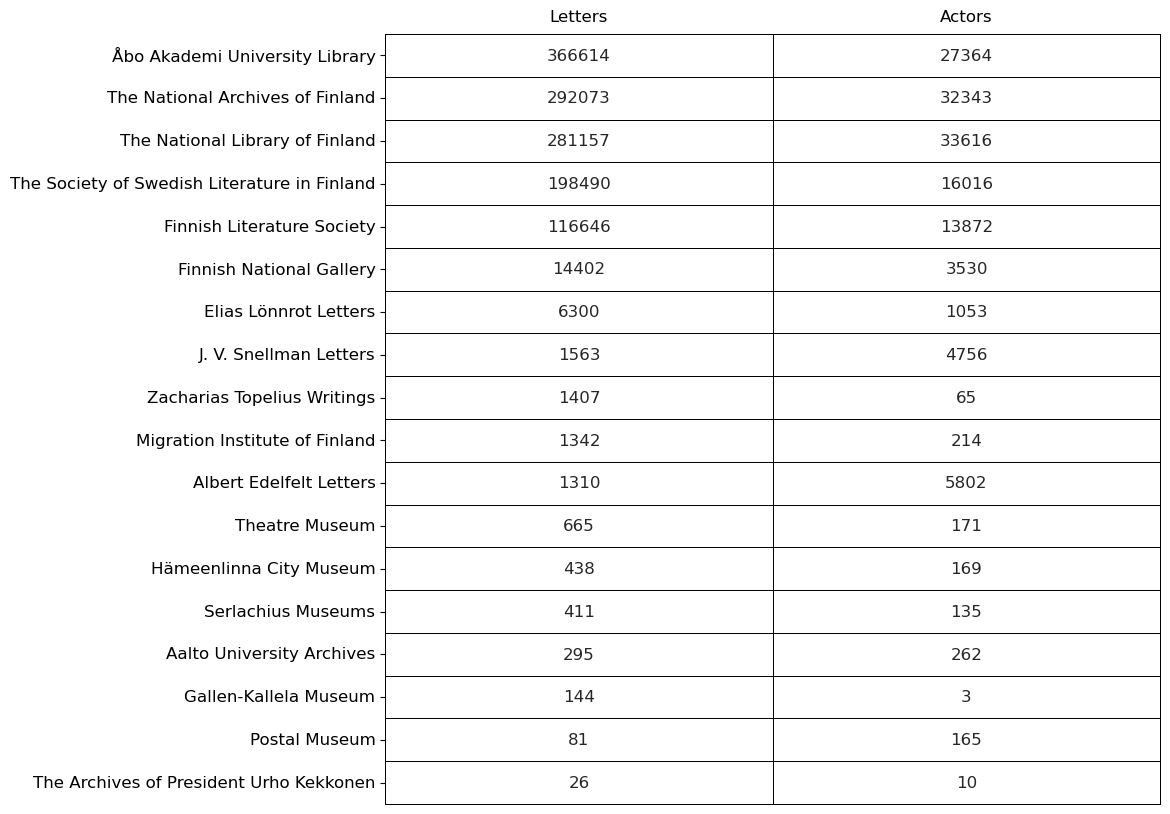

In [ ]:
table_as_figure(df_numbers, "datasource")

In [ ]:
get_letter_duplicates(df_edges, aggregates=["sending_place", "target_place"])

date,source,target,datasource,evt,sending_place,target_place,num_datasource
str,str,str,list[str],u32,list[str],list[str],u32
"""26-12-1846""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kuopio"", ""Kuopio""]","[null, null]",2
"""22-11-1845""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kajaani"", ""Kajaani""]","[null, null]",2
"""23-06-1844""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Helsinki"", ""Helsinki""]","[null, null]",2
"""25-05-1848""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kajaani"", ""Kajaani""]","[null, null]",2
"""01-11-1845""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[null, null]","[null, null]",2
…,…,…,…,…,…,…,…
"""24-10-1845""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kajaani"", ""Kajaani""]","[null, null]",2
"""18-04-1846""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kajaani"", ""Kajaani""]","[null, null]",2
"""26-09-1845""","""http://ldf.fi/coco/provided/p0…","""http://ldf.fi/coco/provided/p0…","[""Elias Lönnrot Letters"", ""J. V. Snellman Letters""]",2,"[""Kajaani"", ""Kajaani""]","[null, null]",2


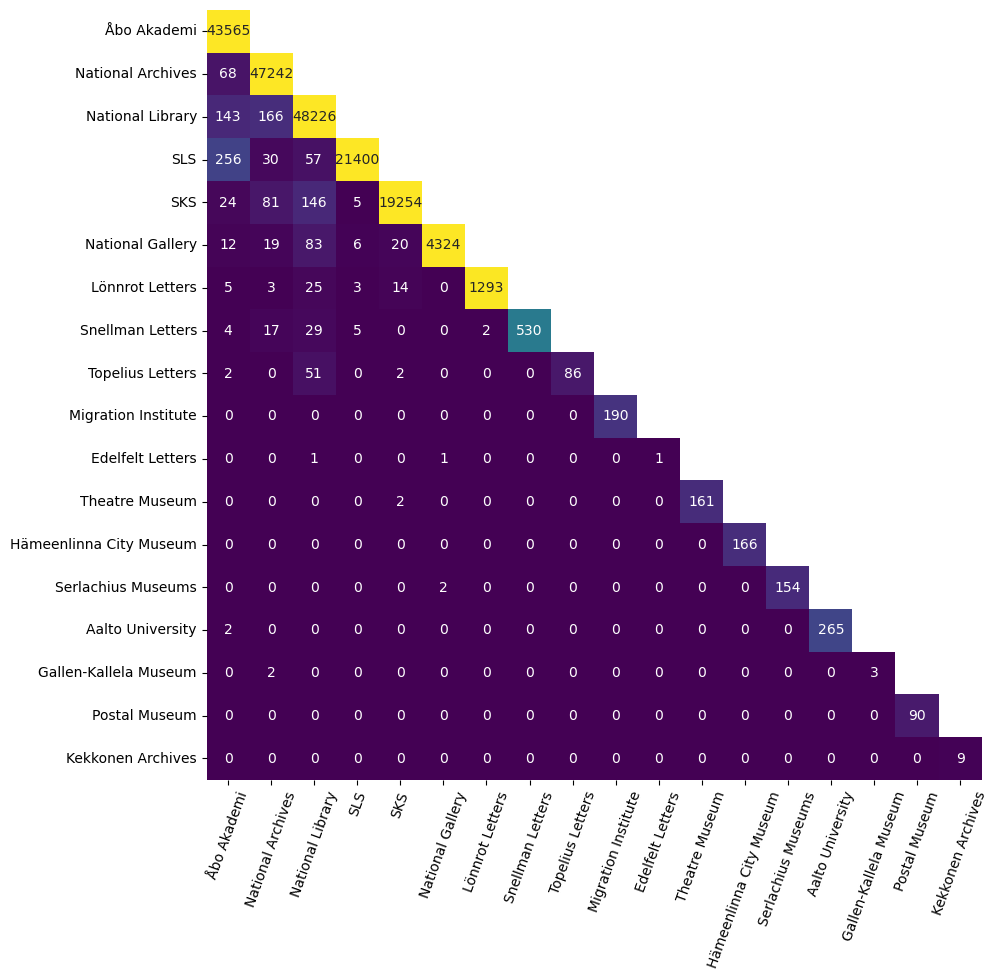

In [184]:
# Shared sender-receiver pairs among datasources
G_shared = shared_actor_pairs_graph(df_edges, groupby="short_sources", weight="actors")
plot_heatmap(G_shared, nodelist=[short_sources[n] for n in list(df_numbers['datasource'])])

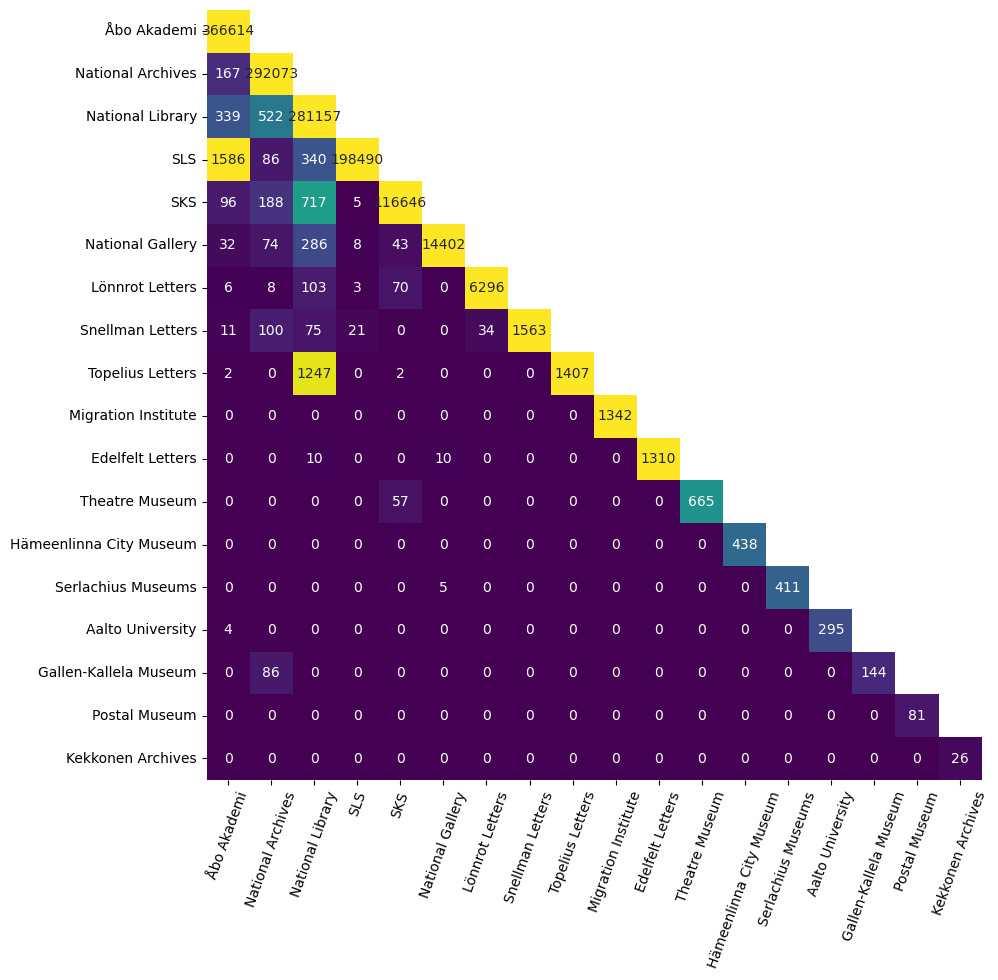

In [185]:
# Potentially shared letters among datasources
G_shared = shared_actor_pairs_graph(df_edges, groupby="short_sources", weight="letters")
plot_heatmap(G_shared, nodelist=[short_sources[n] for n in list(df_numbers['datasource'])])

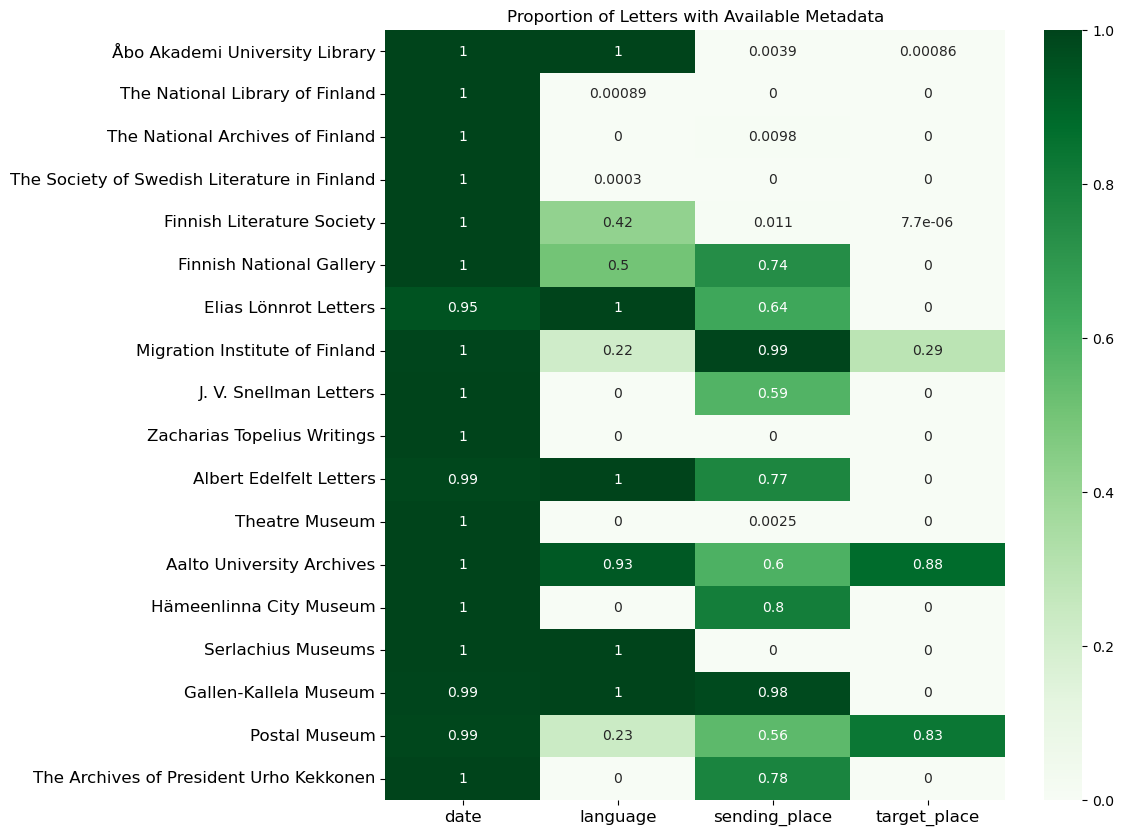

In [ ]:
columns = ["date", "language", "sending_place", "target_place"]
link_metadata(df_edges, columns, title='Proportion of Letters with Available Metadata')

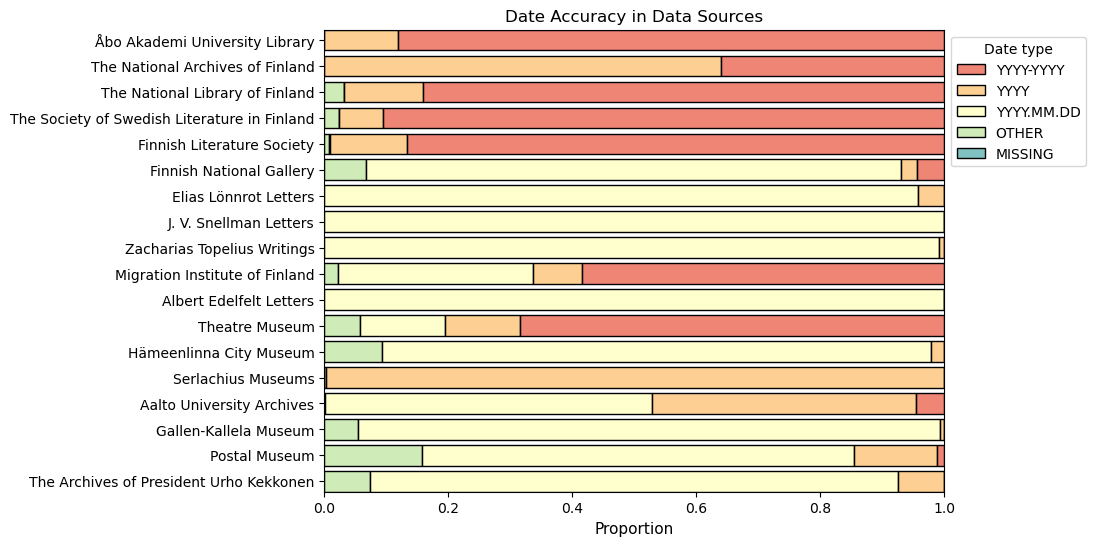

In [ ]:
date_accuracy(df_edges,order=list(df_numbers['datasource']), hue_order=['YYYY-YYYY', 'YYYY', 'YYYY.MM.DD', 'OTHER', 'MISSING'], title="Date Accuracy in Data Sources")

In [ ]:
G_multi = create_multigraph_from_edges(df_edges)

In [ ]:
multisource_nodes, multinode_prop = get_nodes_with_multiple_keys(G_multi) # Get actors present in multiple datasources

print(f"Number of nodes in multiple sources: {len(multisource_nodes)} ({multinode_prop*100:.2f}% out of all the nodes)")

senders_only = [n for n in multisource_nodes if G_multi.in_degree(n, weight="weight") == 0]
receivers_only = [n for n in multisource_nodes if G_multi.out_degree(n, weight="weight") == 0]

print("Belongs to multiple sources but has only sent letters:", len(senders_only), f"({len(senders_only)/len(multisource_nodes)*100:.2f}% of multi source nodes)")
print("Belongs to multiple sources but has only received letters:", len(receivers_only), f"({len(receivers_only)/len(multisource_nodes)*100:.2f}% of multi source nodes)")

Number of nodes in multiple sources: 11312 (10.37% out of all the nodes)
Belongs to multiple sources but has only sent letters: 6719 (59.40% of multi source nodes)
Belongs to multiple sources but has only received letters: 38 (0.34% of multi source nodes)


In [ ]:
high_deg_nodes = [n for n,d in sorted(G_multi.degree(weight="weight"), key=lambda x: x[1], reverse=True) if d > 9]
print(f"Number of nodes in with degree at least 10: {len(high_deg_nodes)} ({len(high_deg_nodes)/G_multi.number_of_nodes()*100:.2f}% out of all the nodes)")

Number of nodes in with degree at least 10: 17545 (16.09% out of all the nodes)


In [ ]:
low_deg_multinodes = [n for n in multisource_nodes if G_multi.degree(n, weight="weight") < 10]
print("Proportion of nodes belonging to multiple sources but low degree: {:.2f}".format(len(low_deg_multinodes)/len(multisource_nodes)))

Proportion of nodes belonging to multiple sources but low degree: 0.40


In [ ]:
# Number of high degree nodes in one or more data sources
high_deg_one = []
high_deg_multi = []
for i, n in enumerate(multisource_nodes):
    if n in high_deg_nodes:
        high_deg_multi.append(n)
    else:
        high_deg_one.append(n)
print(len(high_deg_multi))
print(len(high_deg_one))

6759
4553


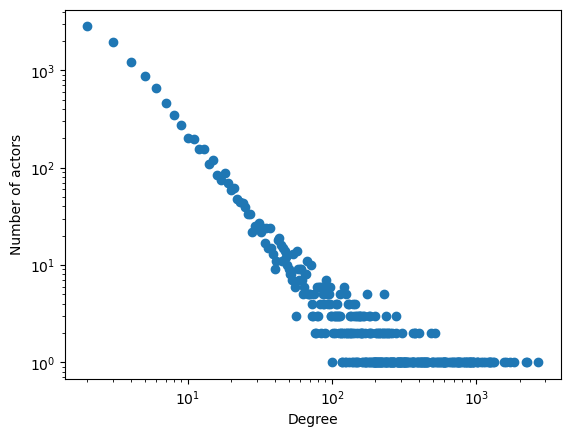

In [ ]:
degree_dist(G_multi, multisource_nodes) # Degree distribution of actors with multiple datasources

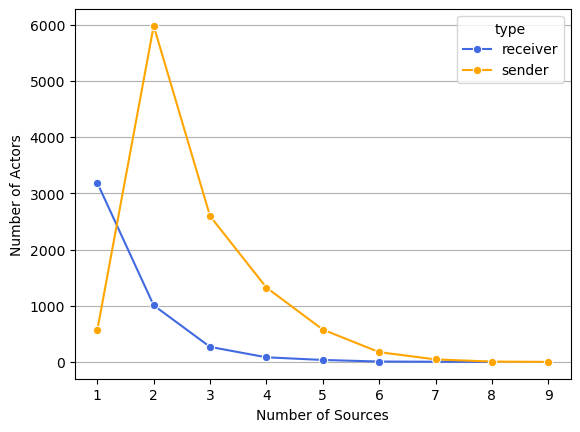

In [ ]:
plot_num_actors_in_source(multisource_nodes)

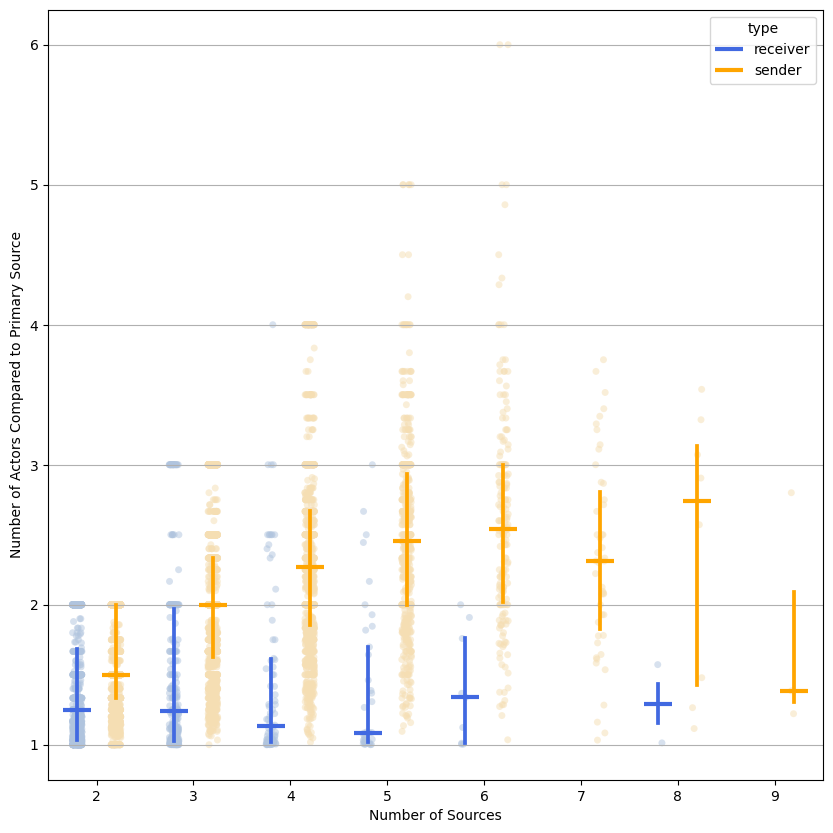

In [ ]:
plot_network_growth(high_deg_multi)

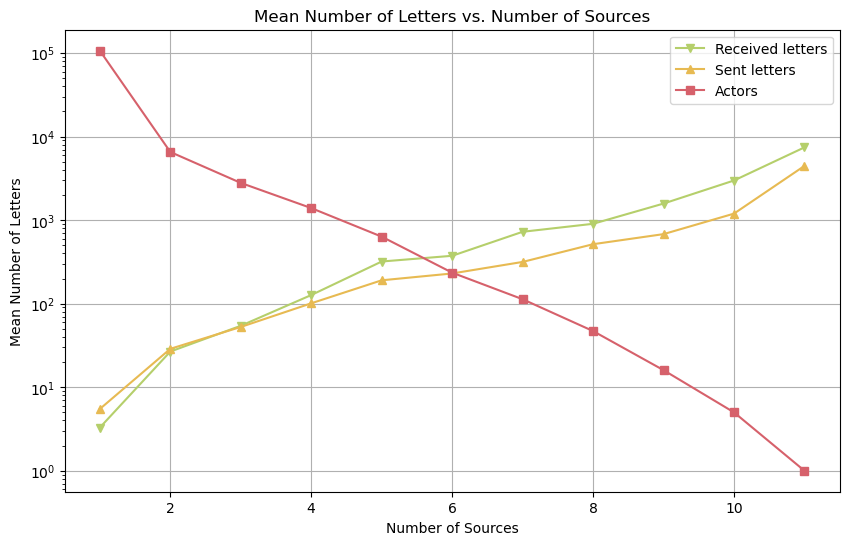

In [190]:
plot_degrees_per_source(df_nodes)

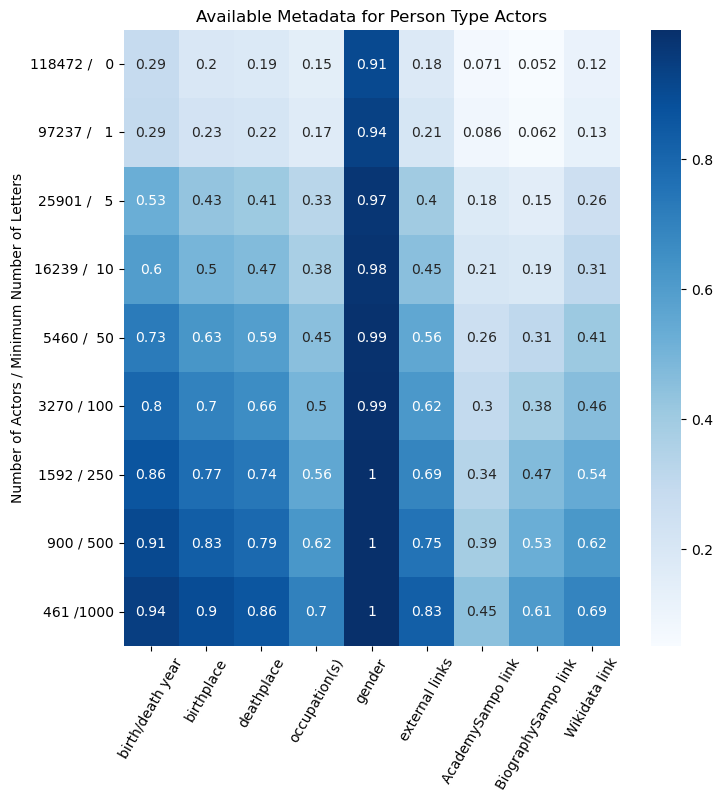

In [216]:
plot_node_metadata(df_nodes, columns=['birthyear', 'birthplace', 'deathplace','occupations','gender','links','yoma_link','nbf_link','wiki_link'],
                    columns_labels=['birth/death year', 'birthplace', 'deathplace','occupation(s)','gender','external links','AcademySampo link','BiographySampo link','Wikidata link'],
                    degrees=[1,5,10,50,100,250,500,1000],
                    title="Available Metadata for Person Type Actors", filters={"type":"Person"})

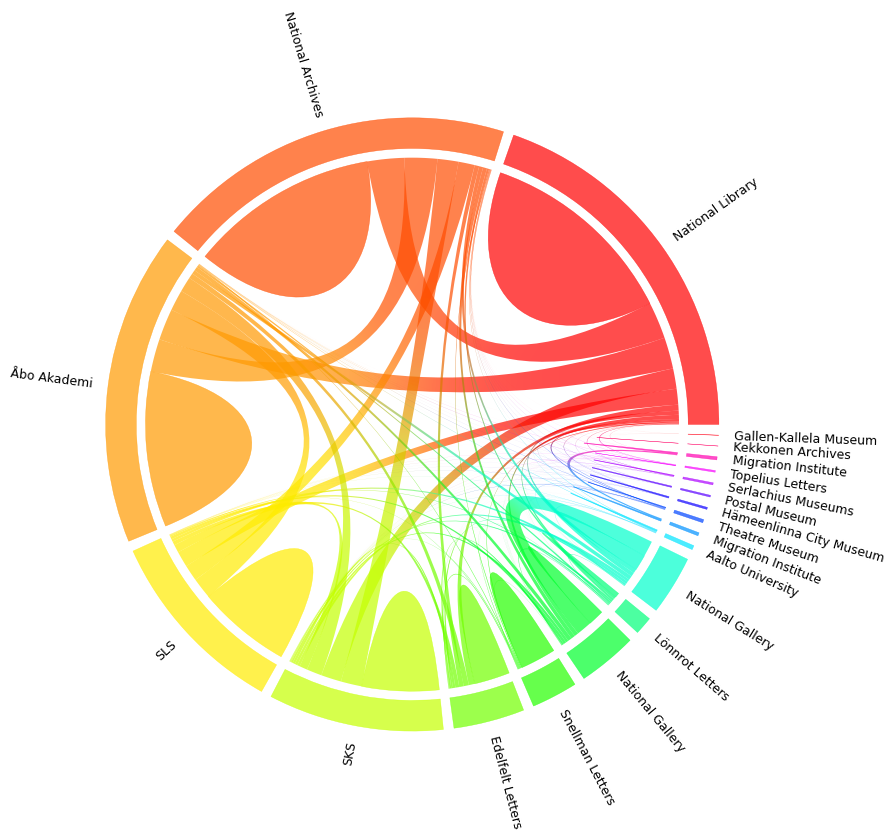

In [228]:
plot_chord_diagram(df_nodes)